In [2]:
import os, sys
import numpy as np
from dipy.data import get_fnames
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools
import matplotlib.pyplot as plt
from skimage import io
import SimpleITK as sitk
%matplotlib inline
%load_ext autoreload
%autoreload 2
fname_moving = get_fnames('reg_o')
fname_static = get_fnames('reg_c')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_registration import register_files, register_translation

In [3]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail_aligned')
fixed_filename = os.path.join(INPUT, '200.tif')
fixed = sitk.ReadImage(fixed_filename, sitk.sitkFloat32)

In [4]:
angle = np.radians(33)
xshift = -130
yshift = -100
transform = sitk.Euler2DTransform()
transform.SetCenter(np.array(fixed.GetSize()) / 2)
transform.SetAngle(angle)
transform.SetTranslation([xshift, yshift])

In [5]:
resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(fixed)
resample.SetInterpolator(sitk.sitkLinear)
resample.SetDefaultPixelValue(0)
resample.SetOutputPixelType(fixed.GetPixelID())

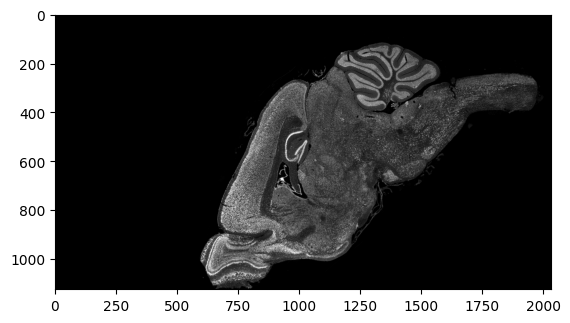

In [6]:
resample.SetTransform(transform)
transformed = resample.Execute(fixed)
plt.imshow(sitk.GetArrayViewFromImage(transformed), cmap='gray')

In [7]:
final_transform = register_files(fixed, transformed)    
finalParameters = final_transform.GetParameters()
fixedParameters = final_transform.GetFixedParameters()

print('set rotation, xshift, yshift', angle, xshift, yshift)
print('rotation, xshift, yshift', finalParameters)
print('center', fixedParameters)

NameError: name 'register_files' is not defined

In [ ]:
moving_resampled = sitk.Resample(transformed, fixed, final_transform, sitk.sitkLinear, 0.0, transformed.GetPixelID())
fig = plt.figure(figsize=(15,8))
plt.imshow(sitk.GetArrayViewFromImage(fixed), cmap='gray')
plt.grid()
plt.title('fixed image', fontsize=10)

fig = plt.figure(figsize=(15, 8))
plt.imshow(sitk.GetArrayViewFromImage(moving_resampled), cmap='gray')
plt.grid()
plt.title('resampled image')

fig = plt.figure(figsize=(15, 8))
plt.title('tranformed image')
plt.grid()
plt.imshow(sitk.GetArrayViewFromImage(transformed), cmap='gray')
    

In [ ]:
def callback_CC(sdr, status):
    # Status indicates at which stage of the optimization we currently are
    # For now, we will only react at the end of each resolution of the scale
    # space
    if status == imwarp.RegistrationStages.SCALE_END:
        # get the current images from the metric
        wmoving = sdr.metric.moving_image
        wstatic = sdr.metric.static_image
        # draw the images on top of each other with different colors
        regtools.overlay_images(wmoving, wstatic, 'Warped moving', 'Overlay',
                                'Warped static')

In [ ]:
regtools.overlay_images(static, moving, 'Static', 'Overlay', 'Moving')

In [ ]:
# this takes a while
dim = static.ndim
metric = SSDMetric(dim)
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)
mapping = sdr.optimize(static, moving)

In [ ]:
regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

In [ ]:
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(static, warped_moving, 'Static', 'Overlay',
                        'Warped moving', 'direct_warp_result.png')

In [ ]:
# Two subplots, unpack the axes array immediately
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
fig.set_size_inches(np.array([24, 20]), forward=False)
ax1.imshow(moving, cmap="gray")
ax1.set_title('moving 100')
ax2.imshow(warped_moving, cmap="gray")
ax2.set_title('warped')
ax3.imshow(static, cmap="gray")
ax3.set_title('static 200')
